In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='gray')
%matplotlib ipympl

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import cv2
from tqdm import tqdm
import random

from stardist import _draw_polygons
from stardist.models import StarDist2D
from csbdeep.utils import normalize
import skimage


from scipy.optimize import dual_annealing, minimize

from tifffile import imsave, imread

2024-02-12 11:14:47.581185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = StarDist2D(None, name = 'stardist_1707523110.807234', \
                           basedir = './models/')
print(model)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.877505, nms_thresh=0.3.
StarDist2D(stardist_1707523110.807234): YXC → YXC
├─ Directory: /Users/matteoscandola/MasterThesis/tracking/models/stardist_1707523110.807234
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cach

In [3]:
def get_frame(cap, frame, x1, y1, x2, y2, w, h, preprocess):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    ret, image = cap.read()
    if preprocess:
        npImage = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        alpha = Image.new('L', (w, h), 0)
        draw = ImageDraw.Draw(alpha)
        draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
        npAlpha = np.array(alpha)
        npImage = npImage*npAlpha
        ind = np.where(npImage == 0)
        npImage[ind] = npImage[200, 200]
        kernel = np.array([[0, -1, 0],
                           [-1, 5,-1],
                           [0, -1, 0]])
        # sharpen image https://en.wikipedia.org/wiki/Kernel_(image_processing)
        npImage = cv2.filter2D(src=npImage, ddepth=-1, kernel=2*kernel)
        npImage = npImage[y1:y2, x1:x2]
        return normalize(npImage)
    elif not preprocess:
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("preprocess must be a boolean")

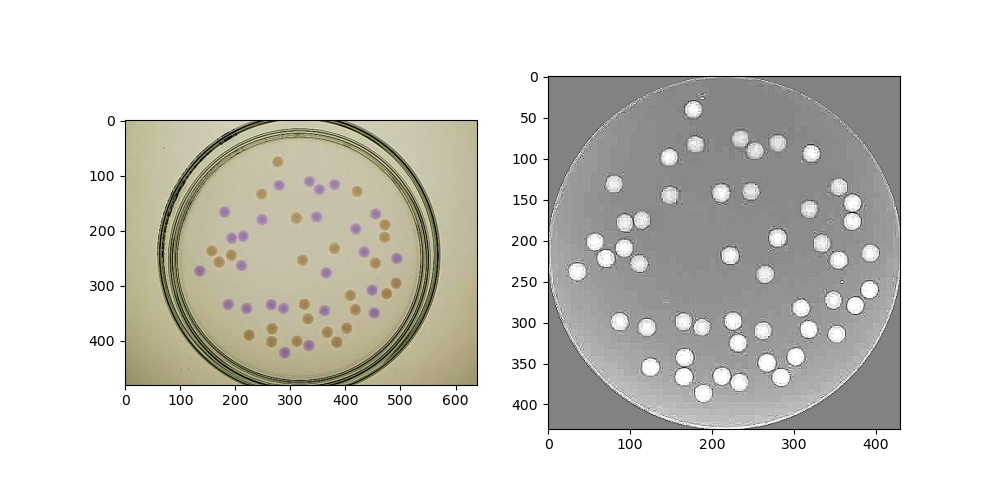

Video has 540000 frames with a resolution of 640x480 and a framerate of 30 fps


In [14]:
video_selection = "25b-25r"
system_name     = f"{video_selection} system"
source_path     = "./data/25b25r-1.mp4" 
xmin, ymin, xmax, ymax = 100, 35, 530, 465
nDrops = 50

save_path = './25b_25r/new_trained/'

video = cv2.VideoCapture(source_path)
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, first_frame = video.read()

preprocessed_img = get_frame(video, 0, xmin, ymin, xmax, ymax, w, h, True)
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5))
ax.imshow(first_frame)
ax1.imshow(preprocessed_img)
plt.show()

w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))
n_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video has {n_frames} frames with a resolution of {w}x{h} and a framerate of {fps} fps")

# BUILD TRAINING DATASET -- USING HOUGH CIRCLE METHOD

In [ ]:
def get_frame_hough(cap, frame, x1, y1, x2, y2, w, h):
	cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
	ret, image = cap.read()
	npImage = np.array(image)
	alpha = Image.new('L', (w, h), 0)
	draw = ImageDraw.Draw(alpha)
	draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
	npAlpha = np.array(alpha)
	npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha 
	ind = np.where(npImage == 0)
	npImage[ind] = npImage[200, 200]
	npImage = npImage[y1:y2, x1:x2]
	return npImage #normalize(npImage)
	
def hough_loc_frame(correct_n, frame, img, parameters):
	found_circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, **parameters)
	if found_circles is not None:
		return np.hstack((found_circles[0], (np.ones((found_circles.shape[1], 1), dtype=int)*frame),\
							np.ones((found_circles.shape[1], 1), dtype=int)*found_circles.shape[1]))
	else:
		return np.hstack((np.ones((1, 3))*-1, np.array([[frame, 0]])))
		
def hough_feature_location(sample_frames, correct_n, params):
	temp = []
	for frame in tqdm(sample_frames):
		img = get_frame_hough(video, frame, xmin, ymin, xmax, ymax, w, h)
		temp.append(hough_loc_frame(correct_n, frame, img, params))
	
	temp_df = pd.DataFrame(np.concatenate([arr for arr in temp]), columns = ["x", "y", "d", "frame", "nDroplets"])
	temp_df["frame"] = temp_df["frame"].astype(int)
	temp_df["nDroplets"] = temp_df["nDroplets"].astype(int)
	err_frames = temp_df.loc[temp_df.nDroplets != correct_n].frame.unique().astype(int)
	loss = err_frames.shape[0]/sample_frames.shape[0]
	return temp_df, err_frames, loss

def optimize_params(x, *args):
	frames, correct_n = args
	params = {"dp":x[0], "minDist":int(x[1]), "param1":x[2], "param2":x[3], "minRadius":int(x[4]), "maxRadius":int(x[5])}
	errs = 0
	for i in tqdm(frames):
		img = get_frame_hough(video, i, xmin, ymin, xmax, ymax, w, h)
		found_circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, **params)
		if (found_circles is not None) and (found_circles.shape[1] == correct_n):
			pass
		else:
			errs += 1
			
	loss = errs/frames.shape[0]
	a = [loss, x[0], int(x[1]), x[2], x[3], int(x[4]), int(x[5])]
	print(a)
	return loss

In [ ]:
n_samples = 100
random.seed(0)
sample_frames = np.sort(np.array(random.sample(range(n_frames), n_samples)), axis=0)

test_params = {"dp":1.5, "minDist":10, "param1":20, "param2":0.7, "minRadius":5, "maxRadius":30}

temp_df, err_frames, loss = hough_feature_location(sample_frames, nDrops, test_params)
print(loss, err_frames)
temp_df_test = temp_df.loc[temp_df.frame == err_frames[1]]
test_img = get_frame_hough(video, err_frames[1], xmin, ymin, xmax, ymax, w, h)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(test_img, cmap="gray")
for i in range(temp_df_test.nDroplets.iloc[0]):
    circle = plt.Circle((temp_df_test.x.iloc[i], temp_df_test.y.iloc[i]), temp_df_test.d.iloc[i], color='r', fill=True, alpha=0.5)
    ax.add_artist(circle)
ax.set(xticks=[], yticks=[], title=f"Frame {err_frames[1]} -- {temp_df_test.nDroplets.iloc[0]} droplets")
plt.show()

In [ ]:
# paramters of HoughCircles --> dp, minDist, param1, param2, minRadius, maxRadius
init_guess =  [2, 5, 20, 0.7, 7, 12] # initial guess for the parameters
params_bounds = [(1, 3), (1, 10), (1, 100), (0.3, 1), (5, 10), (10, 15)] # bounds for the parameters

opt_result = dual_annealing(optimize_params, x0 = init_guess, args = (sample_frames, nDrops), bounds = params_bounds, maxiter = 2000)

# TEST

In [ ]:
save_path = './25b_25r/test/'

In [ ]:
if 1:
    n_samples = 1000
    random.seed(0)
    sample_frames = np.sort(np.array(random.sample(range(n_frames), n_samples)), axis=0)
    test_frame = get_frame(video, sample_frames[-1], xmin, ymin, xmax, ymax, w, h, True)

    sample_video = np.zeros((n_samples, test_frame.shape[0], test_frame.shape[1]), dtype=test_frame.dtype)
    for i in tqdm(range(len(sample_frames))):
        sample_video[i] = get_frame(video, sample_frames[i], xmin, ymin, xmax, ymax, w, h, True)
        imsave(f"train/test/train_{i}.png", sample_video[i])
    # multipage tif
    #imsave('multipage.tif', sample_video)

In [ ]:
# TEST SETUP
n_samples = 10000
#sample_frames = np.linspace(0, n_frames - 1, n_samples, dtype=int)
random.seed(0)
sample_frames = np.sort(np.array(random.sample(range(n_frames), n_samples)), axis=0)

img = get_frame(video, sample_frames[-1], xmin, ymin, xmax, ymax, w, h, True)
labels_test, dict_test = model.predict_instances(img, predict_kwargs = {'verbose':False}) 
test = skimage.measure.regionprops_table(labels_test, properties=('centroid', 'area'))

fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 6), sharex=True, sharey=True)
coord, points, prob = dict_test['coord'], dict_test['points'], dict_test['prob']
ax.imshow(img, cmap='gray'); 
ax.set(title = 'Preprocessed Image', xlabel='X [px]', ylabel='Y [px]')
ax1.imshow(img, cmap='gray'); 
_draw_polygons(coord, points, prob, show_dist=True)
ax1.set(title = f"Stardist result", xlabel='X [px]', ylabel='Y [px]')
plt.suptitle(f"Stardist result on frame {sample_frames[-1]}")
plt.tight_layout()
plt.savefig(save_path + f'example_sharp2.png', dpi = 500)
plt.close()

if 0:
    area, x, y, prob, framesList = [], [], [], [], []
    for frame in tqdm(sample_frames):
        segmented_image, dict_test = model.predict_instances(get_frame(video, frame, xmin, ymin, xmax, ymax, w, h, True), \
                                                            predict_kwargs = {'verbose' : False})
        test = skimage.measure.regionprops_table(segmented_image, properties=('centroid', 'area'))

        area   += list(test['area'])
        y      += list(test['centroid-0'])
        x      += list(test['centroid-1'])
        prob   += list(dict_test['prob'])
        framesList += list(np.ones(len(list(test['centroid-0'])))*frame)
    # save data
    print("Saving data...")
    raw_detection_df = pd.DataFrame({'x':x, 'y':y, 'area':area, 'prob':prob, 'frame':framesList})
    raw_detection_df['frame'] = raw_detection_df.frame.astype('int')
    raw_detection_df['r'] = np.sqrt(raw_detection_df.area/np.pi)
    raw_detection_df.sort_values(by=['frame', 'prob'], ascending=[True, False], inplace=True)
    raw_detection_df.to_parquet(save_path + 'df_test_sharp2.parquet')
else:
    raw_detection_df = pd.read_parquet(save_path + 'df_test_10000_sharp2.parquet')

# analyze the result of raw features location
fig, ax = plt.subplots(2, 2, figsize=(8, 4))
ax[0, 0].plot(raw_detection_df.frame.unique(), raw_detection_df.groupby('frame').count().x.values, '.')
ax[0, 0].set(xlabel = 'Frame', ylabel = 'N of droplets', title = 'N of droplets per frame')
ax[0, 1].plot(raw_detection_df.r, '.')
ax[0, 1].set(xlabel = 'Feature index', ylabel = 'Radius [px]', title = 'Radius of features detected')
ax[1, 0].hist(raw_detection_df.r, bins=100, density=True)
ax[1, 0].set(xlabel = 'Radius [px]', ylabel='Density', title='Radius distribution')
ax[1, 1].scatter(raw_detection_df.r, raw_detection_df.prob, s=0.1)
ax[1, 1].set(xlabel = 'Radius [px]', ylabel='Probability', title='Probability distribution')
plt.tight_layout()
plt.savefig(save_path + 'raw_features_sharp2.png', dpi = 500)
plt.close()

try:
    selected_frame = sample_frames[np.where(raw_detection_df.groupby('frame').count().x.values < nDrops)[0][0]]
except:
    selected_frame = sample_frames[np.where(raw_detection_df.groupby('frame').count().x.values != nDrops)[0][0]]

img = get_frame(video, selected_frame, xmin, ymin, xmax, ymax, w, h, True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title(f"Frame {selected_frame}")
ax.imshow(img, cmap='gray')
for i in range(len(raw_detection_df.loc[raw_detection_df.frame == selected_frame])):
    ax.add_artist(plt.Circle((raw_detection_df.loc[raw_detection_df.frame == selected_frame].x.values[i], raw_detection_df.loc[raw_detection_df.frame == selected_frame].y.values[i]), \
                                raw_detection_df.loc[raw_detection_df.frame == selected_frame].r.values[i], color='r', fill=False))
plt.savefig(save_path + f'example_of_spurious_effect_sharp2.png', dpi = 500)
plt.close()

In [ ]:
# filter found features
print("Errors pre filtering:", len(np.where(raw_detection_df.groupby('frame').count().x.values != nDrops)[0]), "/", len(raw_detection_df.frame.unique()))

rmax, rmin = 12, 6.3
filtered_df = raw_detection_df.loc[raw_detection_df.r.between(rmin, rmax)]
filtered_df = filtered_df.groupby('frame').apply(lambda x: x.nlargest(nDrops, 'prob'))
filtered_df = filtered_df.reset_index(drop=True)

print("Errors after filtering:", len(np.where(filtered_df.groupby('frame').count().x.values != nDrops)[0]), "/", len(filtered_df.frame.unique()))
fig, ax = plt.subplots(2, 2, figsize=(8, 4))
ax[0, 0].plot(filtered_df.frame.unique(), filtered_df.groupby('frame').count().x.values, '.')
ax[0, 0].set(xlabel = 'Frame', ylabel = 'N of droplets', title = 'N of droplets per frame')
ax[0, 1].plot(filtered_df.r, '.')
ax[0, 1].set(xlabel = 'Feature index', ylabel = 'Radius [px]', title = 'Radius of features detected')
ax[1, 0].hist(filtered_df.r, bins=100, density=True)
ax[1, 0].set(xlabel = 'Radius [px]', ylabel='Density', title='Radius distribution')
ax[1, 1].scatter(filtered_df.r, filtered_df.prob, s=0.1)
ax[1, 1].set(xlabel = 'Radius [px]', ylabel='Probability', title='Probability distribution')
plt.tight_layout()
plt.savefig(save_path + 'filtered_features_sharp2.png', dpi = 500)
plt.show()

In [ ]:
test_frame = filtered_df.loc[filtered_df.prob == min(filtered_df.prob)].frame.values[0]
img = get_frame(video, test_frame, xmin, ymin, xmax, ymax, w, h, True)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)
ax.set_title(f"Frame {test_frame}")
ax.imshow(img, cmap='gray')
for i in range(len(filtered_df.loc[filtered_df.frame == test_frame])):
    ax.add_artist(plt.Circle((filtered_df.loc[filtered_df.frame == test_frame].x.values[i],\
                            filtered_df.loc[filtered_df.frame == test_frame].y.values[i]), \
                            filtered_df.loc[filtered_df.frame == test_frame].r.values[i], color='r', fill=True, alpha=0.5))
ax.plot(filtered_df.loc[filtered_df.prob == min(filtered_df.prob)].x, filtered_df.loc[filtered_df.prob == min(filtered_df.prob)].y, 'b.')
ax1.imshow(get_frame(video, test_frame, xmin, ymin, xmax, ymax, w, h, False))
plt.show()

# RUN

In [5]:
def detect_features(sample_frames, run_verb, save_verb):
    if run_verb:
        feature_properties_dict = {'frame':[], 'centroid-1':[], 'centroid-0':[], 'area':[], 'r':[], 'eccentricity':[],\
                                   'prob':[], 'area_bbox':[], 'area_convex':[], 'area_filled':[], 'axis_major_length':[],\
                                   'axis_minor_length':[], 'bbox-0':[], 'bbox-1':[], 'bbox-2':[], 'bbox-3':[],\
                                   'equivalent_diameter_area':[], 'euler_number':[], 'extent':[], 'feret_diameter_max':[],\
                                   'inertia_tensor-0-0':[], 'inertia_tensor-0-1':[], 'inertia_tensor-1-0':[],\
                                   'inertia_tensor-1-1':[], 'inertia_tensor_eigvals-0':[], 'inertia_tensor_eigvals-1':[],\
                                   'label':[]}
        for frame in tqdm(sample_frames):
            img = get_frame(video, frame, xmin, ymin, xmax, ymax, w, h, True)
            segmented_image, dict_test = model.predict_instances(img, predict_kwargs = {'verbose' : False})

            feature_properties = skimage.measure.regionprops_table(segmented_image, \
                                                                   properties=('area', 'area_bbox', 'area_convex', 'area_filled',\
                                                                               'axis_major_length', 'axis_minor_length',\
                                                                               'bbox', 'centroid', 'eccentricity', \
                                                                               'equivalent_diameter_area', 'euler_number', 'extent',\
                                                                               'feret_diameter_max', 'inertia_tensor',\
                                                                               'inertia_tensor_eigvals', 'label'))

            for key in feature_properties.keys():
                feature_properties_dict[key] += list(feature_properties[key])
                
            feature_properties_dict['prob']  += list(dict_test['prob'])
            feature_properties_dict['frame'] += list(np.ones(len(list(feature_properties['centroid-0'])))*frame)
        # save data
        print("Saving data to dataframe...")
        feature_properties_dict['r'] = np.sqrt(np.array(feature_properties_dict['area'])/np.pi)
        raw_detection_df = pd.DataFrame(feature_properties_dict)
        raw_detection_df.rename(columns={'centroid-0': 'y', 'centroid-1': 'x'}, inplace=True)
        raw_detection_df['frame'] = raw_detection_df.frame.astype('int')
        raw_detection_df.sort_values(by=['frame', 'prob'], ascending=[True, False], inplace=True)
        if save_verb: 
            raw_detection_df.to_parquet(save_path + f'raw_detection_{video_selection}_from_{startFrame}_to_{endFrame}.parquet')
    else:
        raw_detection_df = pd.read_parquet(save_path + f'raw_detection_{video_selection}_from_{startFrame}_to_{endFrame}.parquet')

    return raw_detection_df

def filter_detection_data(r_min, r_max, raw_detection_df, nDrops):
    # filter found features
    print("Frames with spurious effects pre filtering:", len(np.where(raw_detection_df.groupby('frame').count().x.values != nDrops)[0]), "/", len(raw_detection_df.frame.unique()))

    filtered_df = raw_detection_df.loc[raw_detection_df.r.between(rmin, rmax)]
    filtered_df = filtered_df.groupby('frame').apply(lambda x: x.nlargest(nDrops, 'prob'))
    filtered_df = filtered_df.reset_index(drop=True)

    print("Frames with spurious effects after filtering:", len(np.where(filtered_df.groupby('frame').count().x.values != nDrops)[0]), "/", len(filtered_df.frame.unique()))

    return filtered_df

In [6]:
startFrame = 0
endFrame = 10000
print(f"Processing from {int(startFrame/fps)} s to {int(endFrame/fps)} s")

sample_frames = np.arange(startFrame, endFrame, 1, dtype=int)
run_verb = False
save_verb = False
raw_detection_df = detect_features(sample_frames, run_verb, save_verb)

Processing from 0 s to 333 s


1/1 [==============================] - 0s 467ms/step


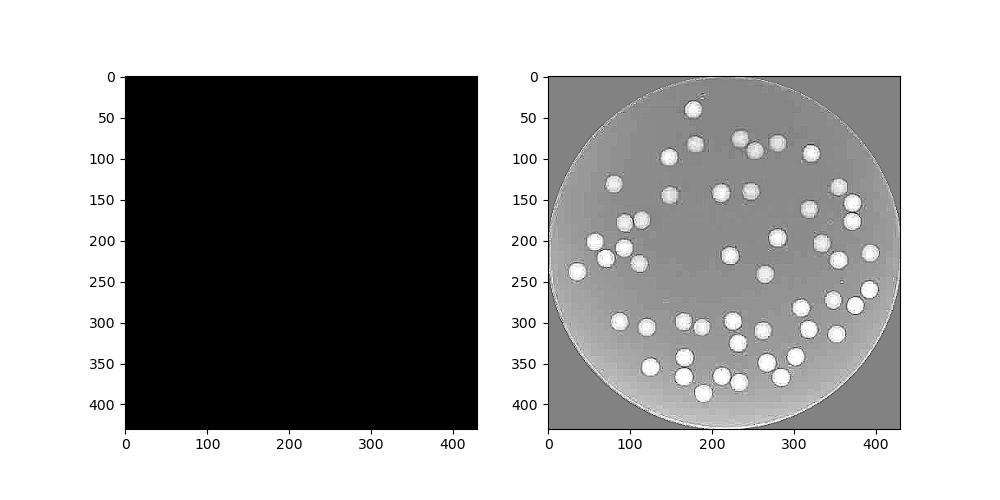

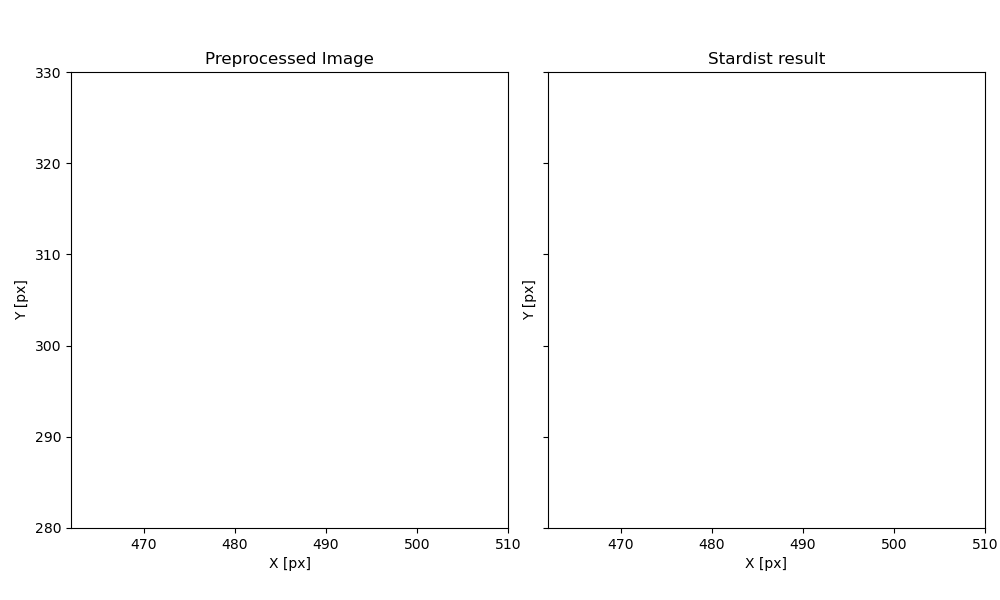

In [18]:
img = get_frame(video, 0, xmin, ymin, xmax, ymax, w, h, True)
segmented_image, dict_test = model.predict_instances(img, predict_kwargs = {'verbose' : True})

fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5))
ax.imshow(segmented_image)
ax1.imshow(img)
plt.show()


fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10,6), sharex=True, sharey=True)
coord, points, prob = dict_test['coord'], dict_test['points'], dict_test['prob']
ax.imshow(img)
ax.set(title = 'Preprocessed Image', xlabel='X [px]', ylabel='Y [px]')
ax1.imshow(img)
_draw_polygons(coord, points, prob, show_dist=True)
ax1.set(title = f"Stardist result", xlabel='X [px]', ylabel='Y [px]')
plt.tight_layout()
ax.set(xlim=(462, 510), ylim = (280, 330))
#plt.savefig(path + 'stardist_example.pdf', format='pdf')
plt.show()

In [ ]:
frame0 = raw_detection_df.loc[(raw_detection_df.frame == 0) & (raw_detection_df.label == 1)]
frame1 = raw_detection_df.loc[(raw_detection_df.frame == 1) & (raw_detection_df.label == 1)]
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(8, 4))
ax.imshow(get_frame(video, sample_frames[0], xmin, ymin, xmax, ymax, w, h, True), cmap='gray')
ax.plot(frame0.x, frame0.y, 'r.')
ax1.imshow(get_frame(video, sample_frames[1], xmin, ymin, xmax, ymax, w, h, True), cmap='gray')
ax1.plot(frame1.x, frame1.y, 'r.')
plt.show()

In [ ]:
# analyze the result of raw features location
n_feature_per_frame = raw_detection_df.groupby('frame').count().x.values

fig, ax = plt.subplots(2, 2, figsize = (8, 4))
ax[0, 0].plot(raw_detection_df.frame.unique(), n_feature_per_frame, '.')
ax[0, 0].set(xlabel = 'Frame', ylabel = 'N of droplets', title = 'N of droplets per frame')
ax[0, 1].plot(raw_detection_df.r, '.')
ax[0, 1].set(xlabel = 'Feature index', ylabel = 'Radius [px]', title = 'Radius of features detected')
ax[1, 0].scatter(raw_detection_df.r, raw_detection_df.eccentricity, s=0.1)
ax[1, 0].set(xlabel = 'Radius [px]', ylabel='Eccentricity', title='R-eccentricity correlation')
ax[1, 1].scatter(raw_detection_df.r, raw_detection_df.prob, s=0.1)
ax[1, 1].set(xlabel = 'Radius [px]', ylabel='Probability', title='R-Probability correlation')
plt.tight_layout()
#plt.savefig(save_path + 'raw_features.png', dpi = 500)
plt.show()

try:
    selected_frame = sample_frames[np.where(raw_detection_df.groupby('frame').count().x.values < nDrops)[0][0]]
except:
    selected_frame = sample_frames[np.where(raw_detection_df.groupby('frame').count().x.values != nDrops)[0][0]]

img = get_frame(video, selected_frame, xmin, ymin, xmax, ymax, w, h, True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title(f"Example of spurious effect at frame {selected_frame}")
ax.imshow(img, cmap='gray')
for i in range(len(raw_detection_df.loc[raw_detection_df.frame == selected_frame])):
    ax.add_artist(plt.Circle((raw_detection_df.loc[raw_detection_df.frame == selected_frame].x.values[i], raw_detection_df.loc[raw_detection_df.frame == selected_frame].y.values[i]), \
                                raw_detection_df.loc[raw_detection_df.frame == selected_frame].r.values[i], color='r', fill=False))
#plt.savefig(save_path + f'example_of_spurious_effect.png', dpi = 500)
plt.show()

In [ ]:
rmax, rmin = 12.5, 6.3
filtered_df = filter_detection_data(rmin, rmax, raw_detection_df, nDrops)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 4))
ax[0, 0].plot(filtered_df.frame.unique(), filtered_df.groupby('frame').count().x.values, '.')
ax[0, 0].set(xlabel = 'Frame', ylabel = 'N of droplets', title = 'N of droplets per frame')
ax[0, 1].plot(filtered_df.r, '.')
ax[0, 1].set(xlabel = 'Feature index', ylabel = 'Radius [px]', title = 'Radius of features detected')
ax[1, 0].hist(filtered_df.r, bins=100, density=True)
ax[1, 0].set(xlabel = 'Radius [px]', ylabel='Density', title='Radius distribution')
ax[1, 1].scatter(filtered_df.r, filtered_df.prob, s=0.1)
ax[1, 1].set(xlabel = 'Radius [px]', ylabel='Probability', title='Probability distribution')
plt.tight_layout()
plt.savefig(save_path + 'filtered_features.png', dpi = 500)
plt.show()


test_frame = sample_frames[np.where(filtered_df.groupby('frame').count().x.values != nDrops)[0][0]]
img = get_frame(video, test_frame, xmin, ymin, xmax, ymax, w, h, True)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)
ax.set(title = f"Filtered detection at frame {test_frame}", xticks=[], yticks=[])
ax.imshow(img, cmap='gray')
for i in range(len(raw_detection_df.loc[raw_detection_df.frame == test_frame])):
    ax.add_artist(plt.Circle((raw_detection_df.loc[raw_detection_df.frame == test_frame].x.values[i],\
                            raw_detection_df.loc[raw_detection_df.frame == test_frame].y.values[i]), \
                            raw_detection_df.loc[raw_detection_df.frame == test_frame].r.values[i], color='r', fill=True, alpha=0.5))
ax1.set(title = f"Filtered detection at frame {test_frame}", xticks=[], yticks=[])
ax1.imshow(img, cmap='gray')
for i in range(len(filtered_df.loc[filtered_df.frame == test_frame])):
    ax1.add_artist(plt.Circle((filtered_df.loc[filtered_df.frame == test_frame].x.values[i],\
                            filtered_df.loc[filtered_df.frame == test_frame].y.values[i]), \
                            filtered_df.loc[filtered_df.frame == test_frame].r.values[i], color='r', fill=True, alpha=0.5))
plt.suptitle(f"Filtered detection at a frame with spurious effects")
plt.show()

test_frame = filtered_df.loc[filtered_df.r == min(filtered_df.r)].frame.values[0]
img = get_frame(video, test_frame, xmin, ymin, xmax, ymax, w, h, True)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)

ax.set(title = f"Filtered detection at frame {test_frame}", xticks=[], yticks=[])
ax.imshow(img, cmap='gray')
for i in range(len(raw_detection_df.loc[raw_detection_df.frame == test_frame])):
    ax.add_artist(plt.Circle((raw_detection_df.loc[raw_detection_df.frame == test_frame].x.values[i],\
                            raw_detection_df.loc[raw_detection_df.frame == test_frame].y.values[i]), \
                            raw_detection_df.loc[raw_detection_df.frame == test_frame].r.values[i], color='r', fill=True, alpha=0.5))
ax1.set(title = f"Filtered detection at frame {test_frame}", xticks=[], yticks=[])
ax1.imshow(img, cmap='gray')
for i in range(len(filtered_df.loc[filtered_df.frame == test_frame])):
    ax1.add_artist(plt.Circle((filtered_df.loc[filtered_df.frame == test_frame].x.values[i],\
                            filtered_df.loc[filtered_df.frame == test_frame].y.values[i]), \
                            filtered_df.loc[filtered_df.frame == test_frame].r.values[i], color='r', fill=True, alpha=0.5))
plt.suptitle(f"Filtered detection with minimum radius detected")
plt.show()

test_frame = filtered_df.loc[filtered_df.r == max(filtered_df.r)].frame.values[0]
img = get_frame(video, test_frame, xmin, ymin, xmax, ymax, w, h, True)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)

ax.set(title = f"Filtered detection at frame {test_frame}", xticks=[], yticks=[])
ax.imshow(img, cmap='gray')
for i in range(len(raw_detection_df.loc[raw_detection_df.frame == test_frame])):
    ax.add_artist(plt.Circle((raw_detection_df.loc[raw_detection_df.frame == test_frame].x.values[i],\
                            raw_detection_df.loc[raw_detection_df.frame == test_frame].y.values[i]), \
                            raw_detection_df.loc[raw_detection_df.frame == test_frame].r.values[i], color='r', fill=True, alpha=0.5))
ax1.set(title = f"Filtered detection at frame {test_frame}", xticks=[], yticks=[])
ax1.imshow(img, cmap='gray')
for i in range(len(filtered_df.loc[filtered_df.frame == test_frame])):
    ax1.add_artist(plt.Circle((filtered_df.loc[filtered_df.frame == test_frame].x.values[i],\
                            filtered_df.loc[filtered_df.frame == test_frame].y.values[i]), \
                            filtered_df.loc[filtered_df.frame == test_frame].r.values[i], color='r', fill=True, alpha=0.5))
plt.suptitle(f"Filtered detection with maximum radius detected")
plt.show()